In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [3]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [5]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [6]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [7]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [8]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [9]:
def build_1d_cnn_custom_conv_3_VGG_DO(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, padding='same', 
                      activation='tanh', input_shape=input_shape)) 
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, padding='same', 
                  activation='tanh')) 
#     model.add(BatchNormalization())
#     model.add(MaxPooling1D(pool_size=3, strides=3))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same', 
                          activation='tanh'))
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same', 
                          activation='tanh'))         
#         model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [10]:
for i in range(1, 10):
    model = build_1d_cnn_custom_conv_3_VGG_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 64)         12352     
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)                (None, 16)                16384016  
Total params: 16,396,624
Trainable params: 16,396,624
Non-trainable params: 0
_________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_30 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 5333, 64)          12352     
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 5333, 64)          12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_75 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 5333, 64)          12352     
_________________________________________________________________
conv1d_77 (Conv1D)           (None, 5333, 64)          12352     
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9831 - acc: 0.3694
Epoch 00001: val_loss improved from inf to 1.64221, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_3_conv_checkpoint/001-1.6422.hdf5
36805/36805 [==============================] - 84s 2ms/sample - loss: 1.9831 - acc: 0.3694 - val_loss: 1.6422 - val_acc: 0.4852
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4150 - acc: 0.5593
Epoch 00002: val_loss improved from 1.64221 to 1.49858, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_3_conv_checkpoint/002-1.4986.hdf5
36805/36805 [==============================] - 82s 2ms/sample - loss: 1.4150 - acc: 0.5593 - val_loss: 1.4986 - val_acc: 0.5362
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1557 - acc: 0.6451
Epoch 00003: val_loss improved from 1.49858 to 1.47

36800/36805 [============================>.] - ETA: 0s - loss: 0.0803 - acc: 0.9792
Epoch 00028: val_loss did not improve from 1.43566
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.0803 - acc: 0.9792 - val_loss: 2.1576 - val_acc: 0.6150
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0744 - acc: 0.9803
Epoch 00029: val_loss did not improve from 1.43566
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.0744 - acc: 0.9803 - val_loss: 2.1276 - val_acc: 0.6096
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0736 - acc: 0.9814
Epoch 00030: val_loss did not improve from 1.43566
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.0736 - acc: 0.9814 - val_loss: 2.1552 - val_acc: 0.6131
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0668 - acc: 0.9826
Epoch 00031: val_loss did not improve from 1.43566
36805/36805 [========================

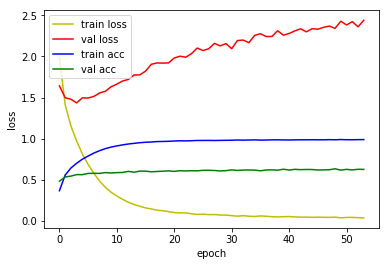

4815/4815 [==============================] - 4s 873us/sample - loss: 1.5296 - acc: 0.5381
Loss: 1.5296365349958743 Accuracy: 0.5381101

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8271 - acc: 0.4186
Epoch 00001: val_loss improved from inf to 1.43232, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_4_conv_checkpoint/001-1.4323.hdf5
36805/36805 [==============================] - 87s 2ms/sample - loss: 1.8270 - acc: 0.4186 - val_loss: 1.4323 - val_acc: 0.5660
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3101 - acc: 0.5975
Epoch 00002: val_loss improved from 1.43232 to 1.20974, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_4_conv_checkpoint/002-1.2097.hdf5
36805/36805 [==============================] - 84s 2ms/sample - loss: 1.3101 - acc: 0.5974 - val_loss: 1.2097 - val_acc: 0.6280
Epoch 3/500
36800/36805 [============================>.] - 

36800/36805 [============================>.] - ETA: 0s - loss: 0.1849 - acc: 0.9498
Epoch 00026: val_loss did not improve from 0.98544
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.1848 - acc: 0.9498 - val_loss: 1.0407 - val_acc: 0.7410
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1703 - acc: 0.9551
Epoch 00027: val_loss did not improve from 0.98544
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.1703 - acc: 0.9551 - val_loss: 1.0548 - val_acc: 0.7331
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1653 - acc: 0.9557
Epoch 00028: val_loss did not improve from 0.98544
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.1653 - acc: 0.9557 - val_loss: 1.0791 - val_acc: 0.7335
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1549 - acc: 0.9584
Epoch 00029: val_loss did not improve from 0.98544
36805/36805 [========================

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0671 - acc: 0.9828
Epoch 00056: val_loss did not improve from 0.98544
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.0671 - acc: 0.9828 - val_loss: 1.2538 - val_acc: 0.7459
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0676 - acc: 0.9824
Epoch 00057: val_loss did not improve from 0.98544
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.0676 - acc: 0.9824 - val_loss: 1.2273 - val_acc: 0.7442
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0637 - acc: 0.9834
Epoch 00058: val_loss did not improve from 0.98544
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.0637 - acc: 0.9833 - val_loss: 1.2394 - val_acc: 0.7424
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0660 - acc: 0.9824
Epoch 00059: val_loss did not improve from 0.98544
36805/36805 [===========

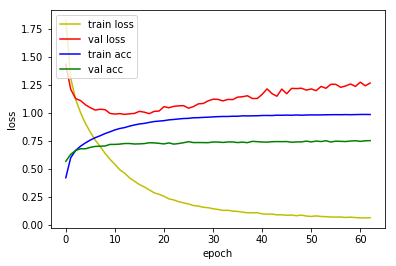

4815/4815 [==============================] - 5s 938us/sample - loss: 1.0711 - acc: 0.6885
Loss: 1.0711028837588221 Accuracy: 0.6884735

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7641 - acc: 0.4332
Epoch 00001: val_loss improved from inf to 1.40032, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_5_conv_checkpoint/001-1.4003.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 1.7640 - acc: 0.4331 - val_loss: 1.4003 - val_acc: 0.5735
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3419 - acc: 0.5861
Epoch 00002: val_loss improved from 1.40032 to 1.15762, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_5_conv_checkpoint/002-1.1576.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 1.3420 - acc: 0.5860 - val_loss: 1.1576 - val_acc: 0.6492
Epoch 3/500
36800/36805 [============================>.] - 

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2627 - acc: 0.9256
Epoch 00026: val_loss did not improve from 0.74542
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.2627 - acc: 0.9256 - val_loss: 0.7563 - val_acc: 0.7959
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2478 - acc: 0.9295
Epoch 00027: val_loss did not improve from 0.74542
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.2478 - acc: 0.9295 - val_loss: 0.7805 - val_acc: 0.7901
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2366 - acc: 0.9320
Epoch 00028: val_loss did not improve from 0.74542
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.2366 - acc: 0.9320 - val_loss: 0.7735 - val_acc: 0.7897
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2193 - acc: 0.9378
Epoch 00029: val_loss did not improve from 0.74542
36805/36805 [===========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0820 - acc: 0.9787
Epoch 00056: val_loss did not improve from 0.74542
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.0820 - acc: 0.9788 - val_loss: 0.9233 - val_acc: 0.8020
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0826 - acc: 0.9780
Epoch 00057: val_loss did not improve from 0.74542
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0826 - acc: 0.9780 - val_loss: 0.9328 - val_acc: 0.7987
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0815 - acc: 0.9780
Epoch 00058: val_loss did not improve from 0.74542
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0815 - acc: 0.9780 - val_loss: 0.9144 - val_acc: 0.7980
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0815 - acc: 0.9780
Epoch 00059: val_loss did not improve from 0.74542
36805/36805 [===========

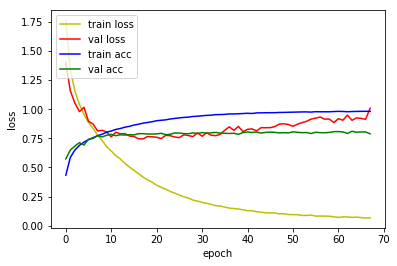

4815/4815 [==============================] - 5s 992us/sample - loss: 0.8078 - acc: 0.7560
Loss: 0.8078143773791946 Accuracy: 0.7559709

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8717 - acc: 0.3947
Epoch 00001: val_loss improved from inf to 1.44631, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_6_conv_checkpoint/001-1.4463.hdf5
36805/36805 [==============================] - 94s 3ms/sample - loss: 1.8717 - acc: 0.3947 - val_loss: 1.4463 - val_acc: 0.5539
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4196 - acc: 0.5567
Epoch 00002: val_loss improved from 1.44631 to 1.20276, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_6_conv_checkpoint/002-1.2028.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 1.4195 - acc: 0.5567 - val_loss: 1.2028 - val_acc: 0.6466
Epoch 3/500
36800/36805 [============================>.] - 

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4143 - acc: 0.8797
Epoch 00024: val_loss improved from 0.49191 to 0.48925, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_6_conv_checkpoint/024-0.4893.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.4144 - acc: 0.8796 - val_loss: 0.4893 - val_acc: 0.8605
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4030 - acc: 0.8832
Epoch 00025: val_loss did not improve from 0.48925
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.4030 - acc: 0.8832 - val_loss: 0.5048 - val_acc: 0.8605
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3913 - acc: 0.8845
Epoch 00026: val_loss improved from 0.48925 to 0.48623, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_6_conv_checkpoint/026-0.4862.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.3913 - acc: 0.8845

Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2044 - acc: 0.9365
Epoch 00050: val_loss did not improve from 0.41477
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.2044 - acc: 0.9365 - val_loss: 0.4169 - val_acc: 0.8875
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2009 - acc: 0.9404
Epoch 00051: val_loss did not improve from 0.41477
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.2009 - acc: 0.9404 - val_loss: 0.4446 - val_acc: 0.8870
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1978 - acc: 0.9410
Epoch 00052: val_loss improved from 0.41477 to 0.41344, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_6_conv_checkpoint/052-0.4134.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1978 - acc: 0.9410 - val_loss: 0.4134 - val_acc: 0.8877
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s

Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1110 - acc: 0.9659
Epoch 00079: val_loss did not improve from 0.41269
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1110 - acc: 0.9659 - val_loss: 0.4374 - val_acc: 0.8977
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1084 - acc: 0.9666
Epoch 00080: val_loss did not improve from 0.41269
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1084 - acc: 0.9666 - val_loss: 0.4862 - val_acc: 0.8887
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1069 - acc: 0.9675
Epoch 00081: val_loss improved from 0.41269 to 0.41258, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_6_conv_checkpoint/081-0.4126.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1069 - acc: 0.9675 - val_loss: 0.4126 - val_acc: 0.9010
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s

36800/36805 [============================>.] - ETA: 0s - loss: 0.0692 - acc: 0.9801
Epoch 00108: val_loss did not improve from 0.41258
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0692 - acc: 0.9801 - val_loss: 0.4864 - val_acc: 0.8926
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0709 - acc: 0.9792
Epoch 00109: val_loss did not improve from 0.41258
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0709 - acc: 0.9792 - val_loss: 0.4908 - val_acc: 0.8975
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0630 - acc: 0.9815
Epoch 00110: val_loss did not improve from 0.41258
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0630 - acc: 0.9816 - val_loss: 0.4784 - val_acc: 0.8991
Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0675 - acc: 0.9801
Epoch 00111: val_loss did not improve from 0.41258
36805/36805 [=====================

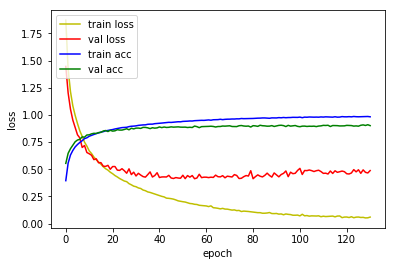

4815/4815 [==============================] - 5s 966us/sample - loss: 0.4960 - acc: 0.8692
Loss: 0.4959927596283355 Accuracy: 0.86915886

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9403 - acc: 0.3746
Epoch 00001: val_loss improved from inf to 1.47570, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_7_conv_checkpoint/001-1.4757.hdf5
36805/36805 [==============================] - 97s 3ms/sample - loss: 1.9403 - acc: 0.3746 - val_loss: 1.4757 - val_acc: 0.5460
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4427 - acc: 0.5506
Epoch 00002: val_loss improved from 1.47570 to 1.16888, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_7_conv_checkpoint/002-1.1689.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 1.4428 - acc: 0.5506 - val_loss: 1.1689 - val_acc: 0.6557
Epoch 3/500
36800/36805 [============================>.] -

36800/36805 [============================>.] - ETA: 0s - loss: 0.3341 - acc: 0.9038
Epoch 00022: val_loss improved from 0.32063 to 0.30861, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_7_conv_checkpoint/022-0.3086.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.3341 - acc: 0.9038 - val_loss: 0.3086 - val_acc: 0.9124
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3231 - acc: 0.9067
Epoch 00023: val_loss improved from 0.30861 to 0.30514, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_7_conv_checkpoint/023-0.3051.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.3231 - acc: 0.9068 - val_loss: 0.3051 - val_acc: 0.9166
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3048 - acc: 0.9115
Epoch 00024: val_loss did not improve from 0.30514
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.3049 - acc: 0.9115 - val_loss: 

36800/36805 [============================>.] - ETA: 0s - loss: 0.1627 - acc: 0.9507
Epoch 00049: val_loss did not improve from 0.22846
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1627 - acc: 0.9507 - val_loss: 0.2389 - val_acc: 0.9373
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1604 - acc: 0.9526
Epoch 00050: val_loss improved from 0.22846 to 0.22574, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_7_conv_checkpoint/050-0.2257.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1604 - acc: 0.9526 - val_loss: 0.2257 - val_acc: 0.9352
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1518 - acc: 0.9549
Epoch 00051: val_loss improved from 0.22574 to 0.22217, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_7_conv_checkpoint/051-0.2222.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.1518 - acc: 0.9549 - val_loss: 

Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0854 - acc: 0.9742
Epoch 00077: val_loss did not improve from 0.21455
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0854 - acc: 0.9742 - val_loss: 0.2329 - val_acc: 0.9404
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0852 - acc: 0.9743
Epoch 00078: val_loss did not improve from 0.21455
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0852 - acc: 0.9743 - val_loss: 0.2545 - val_acc: 0.9336
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0784 - acc: 0.9765
Epoch 00079: val_loss did not improve from 0.21455
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0784 - acc: 0.9765 - val_loss: 0.2194 - val_acc: 0.9436
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0764 - acc: 0.9766
Epoch 00080: val_loss did not improve from 0.21455
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0441 - acc: 0.9867
Epoch 00106: val_loss did not improve from 0.20855
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0440 - acc: 0.9867 - val_loss: 0.2677 - val_acc: 0.9399
Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0417 - acc: 0.9880
Epoch 00107: val_loss did not improve from 0.20855
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0417 - acc: 0.9880 - val_loss: 0.2542 - val_acc: 0.9436
Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0451 - acc: 0.9863
Epoch 00108: val_loss did not improve from 0.20855
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0451 - acc: 0.9863 - val_loss: 0.2844 - val_acc: 0.9362
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0458 - acc: 0.9863
Epoch 00109: val_loss did not improve from 0.20855
36805/36805 [=====================

Epoch 136/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0321 - acc: 0.9912
Epoch 00136: val_loss did not improve from 0.20855
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0321 - acc: 0.9912 - val_loss: 0.2749 - val_acc: 0.9425
Epoch 137/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0281 - acc: 0.9918
Epoch 00137: val_loss did not improve from 0.20855
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0281 - acc: 0.9918 - val_loss: 0.2823 - val_acc: 0.9406
Epoch 138/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0265 - acc: 0.9921
Epoch 00138: val_loss did not improve from 0.20855
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0265 - acc: 0.9921 - val_loss: 0.2955 - val_acc: 0.9397
Epoch 139/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0284 - acc: 0.9916
Epoch 00139: val_loss did not improve from 0.20855
36805/36805 [=======

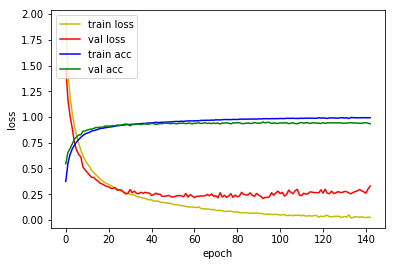

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2569 - acc: 0.9271
Loss: 0.2569013264575666 Accuracy: 0.9271028

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9532 - acc: 0.3645
Epoch 00001: val_loss improved from inf to 1.41860, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_8_conv_checkpoint/001-1.4186.hdf5
36805/36805 [==============================] - 100s 3ms/sample - loss: 1.9531 - acc: 0.3645 - val_loss: 1.4186 - val_acc: 0.5597
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4373 - acc: 0.5455
Epoch 00002: val_loss improved from 1.41860 to 1.13758, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_8_conv_checkpoint/002-1.1376.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 1.4373 - acc: 0.5455 - val_loss: 1.1376 - val_acc: 0.6532
Epoch 3/500
36800/36805 [============================>.] - E

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1711 - acc: 0.9498
Epoch 00024: val_loss improved from 0.16926 to 0.16194, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_8_conv_checkpoint/024-0.1619.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1711 - acc: 0.9497 - val_loss: 0.1619 - val_acc: 0.9534
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1656 - acc: 0.9519
Epoch 00025: val_loss did not improve from 0.16194
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1657 - acc: 0.9518 - val_loss: 0.1802 - val_acc: 0.9488
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1588 - acc: 0.9538
Epoch 00026: val_loss did not improve from 0.16194
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1588 - acc: 0.9537 - val_loss: 0.1886 - val_acc: 0.9467
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0517 - acc: 0.9846
Epoch 00053: val_loss did not improve from 0.14713
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0517 - acc: 0.9846 - val_loss: 0.1875 - val_acc: 0.9522
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0511 - acc: 0.9846
Epoch 00054: val_loss did not improve from 0.14713
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0511 - acc: 0.9845 - val_loss: 0.1655 - val_acc: 0.9571
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0497 - acc: 0.9850
Epoch 00055: val_loss did not improve from 0.14713
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0497 - acc: 0.9850 - val_loss: 0.1584 - val_acc: 0.9588
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0476 - acc: 0.9852
Epoch 00056: val_loss did not improve from 0.14713
36805/36805 [===========

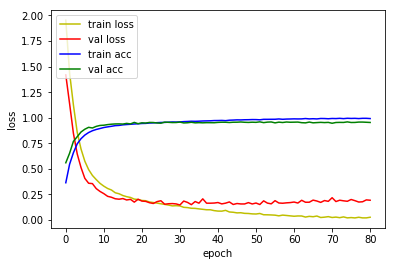

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.1982 - acc: 0.9387
Loss: 0.1981866773662785 Accuracy: 0.9387331

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5118 - acc: 0.5205
Epoch 00001: val_loss improved from inf to 0.89264, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_9_conv_checkpoint/001-0.8926.hdf5
36805/36805 [==============================] - 104s 3ms/sample - loss: 1.5117 - acc: 0.5205 - val_loss: 0.8926 - val_acc: 0.7426
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8149 - acc: 0.7532
Epoch 00002: val_loss improved from 0.89264 to 0.52904, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_DO_9_conv_checkpoint/002-0.5290.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.8149 - acc: 0.7532 - val_loss: 0.5290 - val_acc: 0.8512
Epoch 3/500
36800/36805 [============================>.] - E

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0757 - acc: 0.9768
Epoch 00026: val_loss did not improve from 0.12742
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0757 - acc: 0.9768 - val_loss: 0.1278 - val_acc: 0.9646
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0683 - acc: 0.9799
Epoch 00027: val_loss did not improve from 0.12742
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0683 - acc: 0.9799 - val_loss: 0.1410 - val_acc: 0.9609
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0677 - acc: 0.9787
Epoch 00028: val_loss did not improve from 0.12742
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0677 - acc: 0.9787 - val_loss: 0.1419 - val_acc: 0.9630
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0638 - acc: 0.9805
Epoch 00029: val_loss did not improve from 0.12742
36805/36805 [===========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0191 - acc: 0.9943
Epoch 00056: val_loss did not improve from 0.12742
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0191 - acc: 0.9943 - val_loss: 0.1658 - val_acc: 0.9604
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0180 - acc: 0.9947
Epoch 00057: val_loss did not improve from 0.12742
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0180 - acc: 0.9947 - val_loss: 0.1705 - val_acc: 0.9627
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0179 - acc: 0.9940
Epoch 00058: val_loss did not improve from 0.12742
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0179 - acc: 0.9940 - val_loss: 0.1504 - val_acc: 0.9658
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0137 - acc: 0.9958
Epoch 00059: val_loss did not improve from 0.12742
36805/36805 [===========

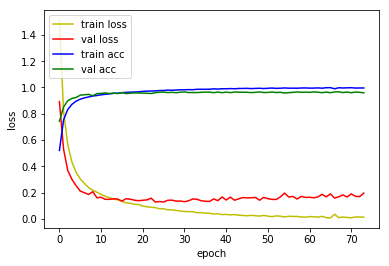

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.1677 - acc: 0.9510
Loss: 0.16767958380351558 Accuracy: 0.9509865



In [11]:
for i in range(3, 10):
    base = '1D_CNN_custom_conv_3_VGG_tanh_DO'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_conv_3_VGG_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [12]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_conv_3_VGG_tanh_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_tanh_DO_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_92 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_93 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_94 (Conv1D)           (None, 5333, 64)          12352     
_________________________________________________________________
conv1d_95 (Conv1D)           

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.4960 - acc: 0.8692
Loss: 0.4959927596283355 Accuracy: 0.86915886

1D_CNN_custom_conv_3_VGG_tanh_DO_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_126 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
conv1d_127 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_128 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_129 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_50 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_130 (Conv1D)        

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1677 - acc: 0.9510
Loss: 0.16767958380351558 Accuracy: 0.9509865


In [13]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO_BN'

with open(path.join(log_dir, base+'_last'), 'w') as log_file:
    for i in range(3, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + '000_last.hdf5'

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_tanh_DO_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_92 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_93 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_94 (Conv1D)           (None, 5333, 64)          12352     
_________________________________________________________________
conv1d_95 (Conv1D)           

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.5840 - acc: 0.8733
Loss: 0.5839728851277509 Accuracy: 0.8733126

1D_CNN_custom_conv_3_VGG_tanh_DO_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_126 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
conv1d_127 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_128 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_129 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_50 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_130 (Conv1D)         

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2570 - acc: 0.9460
Loss: 0.25696964077960976 Accuracy: 0.94600207
